In [1]:
!pip install -U plotly

     |████████████████████████████████| 13.2MB 327kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import plotly 
import plotly.express as px

import tensorflow as tf
import pandas as pd
import numpy as np 
import seaborn as sns

import IPython
import IPython.display

from sklearn import preprocessing, metrics  
import matplotlib.pyplot as plt
import importlib.util
import datetime
import shutil
import os

import keras.backend as K


from google.colab import drive
import sys

%load_ext tensorboard

# np.set_printoptions(threshold=np.inf)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.plotting.backend = "plotly"
drive.mount("/content/drive")
spec = importlib.util.spec_from_file_location("generalUtilityFunctions.py","./drive/MyDrive/Colab_Notebooks/generalUtilityFunctions.py")
gUF = importlib.util.module_from_spec(spec)
spec.loader.exec_module(gUF)

In [ ]:
# inspired by 
# https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
# https://www.tensorflow.org/tutorials/text/text_generation

df = pd.read_pickle("./drive/MyDrive/Colab_Notebooks/bachelor_data/DATA_hourly_inside.pkl")
df['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
df.reset_index(inplace= True)

df.columns = [' '.join(col).strip().replace(' ','_') for col in df.columns.values]

times_s = df['TimeStamp'].map(datetime.datetime.timestamp)
df.drop('TimeStamp', 1, inplace=True)

day = 24*60*60
year = (365.2425)*day


df['yearsin'] = np.sin(times_s * (2 * np.pi / year))
df['yearcos'] = np.cos(times_s * (2 * np.pi / year))

print(f'{list(df.columns)}, len: {len(list(df.columns))}')

df.head()


# create train, val and test df
n = len(df)
train_n = int(n*0.7)
val_n = int(n*0.9)
train_df = df[:train_n]
val_df = df[train_n:val_n]
test_df = df[val_n:]

num_features = df.shape[1]
print(num_features)
print(train_df.shape)

# normalize the data
train_mean = train_df.mean()
train_std = train_df.std()
# print(train_mean.shape)


train_df_normal = (train_df - train_mean) / train_std
val_df_normal = (val_df - train_mean) / train_std
test_df_normal = (test_df - train_mean) / train_std

df_normal = (df - train_mean) / train_std

# https://www.geeksforgeeks.org/python-pandas-melt/
df_normal = df_normal.melt(var_name='Column', value_name='Normalized')

fill_value = -7.0

train_df_normal_fill = train_df_normal.fillna(fill_value)
val_df_normal_fill = val_df_normal.fillna(fill_value)
test_df_normal_fill = test_df_normal.fillna(fill_value)





['n_LIND', 'n_NEUH', 'n_NITT', 'n_RODI', 'n_SCHK', 'n_TEIS', 'n_WEID', 'n_KIBE', 'n_LAML', 'n_REGE', 'n_ZWIE', 'n_POES', 'n_KITE', 'n_SANK', 'q_CHAU', 'q_FURT', 'q_GOGM', 'q_HIRB', 'q_KIEN', 'q_KOET', 'q_KOTH', 'q_LEMI', 'q_LOHB', 'q_LOHM', 'q_MARI', 'q_OESB', 'q_SAEG', 'q_TEAC', 'q_TEAT', 'q_VIER', 'q_ZWIE', 'q_ZWIG', 'rflu_REGE', 'rflu_POES', 'rflu_KITE', 'tlu_SCHK', 'tlu_REGE', 'tlu_POES', 'tlu_KITE', 'ttau_REGE', 'xglob_POES', 'xglob_KITE', 'xludr_REGE', 'xwind_REGE', 'xwind_KITE', 'zsos_REGE', 'yearsin', 'yearcos'], len: 48
48
(79615, 48)


In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_normal_fill, val_df=val_df_normal_fill, test_df=test_df_normal_fill,
               label_columns=None, shuffle = False, batch_size = 32):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # store some more options
    self.shuffle = shuffle
    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

  def plot(self, model=None, plot_col='q_MARI', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)

    # todo: discuss parameters !!!
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=self.shuffle,
      batch_size=self.batch_size)
    
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

    
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  @example.setter
  def example(self, value):
      self.example = value

In [ ]:

def pick_median(arg_tensor):
    the_upper_tensor = tensorflow.contrib.distributions.percentile(arg_tensor, 50, interpolation='higher')
    the_lower_tensor = tensorflow.contrib.distributions.percentile(arg_tensor, 50, interpolation='lower')

    final_tensor = (the_upper_tensor + the_lower_tensor) / 2
    # print(the_count.eval(session=keras.backend.get_session()))

    return final_tensor

def max_error(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  K.max(y_pred- y_true)


def median_absolute_error(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  pick_median(K.abs(y_pred- y_true))

def rev_metric(y_true, y_pred):
    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return (K.sum(y_pred) - K.sum(y_true)) / K.sum(y_true) * 100


def nse_metric(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  
  return 1 - (K.sum((y_pred - y_true) ** 2) / K.sum((y_true - K.mean(y_true))**2))



def get_metrics():
  rmse =  tf.keras.metrics.RootMeanSquaredError()
  meae = tf.keras.metrics.MeanAbsoluteError()
  
  max_err = max_error
  rev = rev_metric
  nse = nse_metric
  
  return [rmse, nse,  meae, max_err, rev]



In [ ]:
# abc

def pick_median(arg_tensor):
    the_upper_tensor = tf.contrib.distributions.percentile(arg_tensor, 50, interpolation='higher')
    the_lower_tensor = tf.contrib.distributions.percentile(arg_tensor, 50, interpolation='lower')

    final_tensor = (the_upper_tensor + the_lower_tensor) / 2
    # print(the_count.eval(session=keras.backend.get_session()))

    return final_tensor

def maxe(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  K.max(y_pred- y_true)


def mae(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  pick_median(K.abs(y_pred- y_true))

def rev(y_true, y_pred):
    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return (K.sum(y_pred) - K.sum(y_true)) / K.sum(y_true) * 100


def nse(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  
  return 1 - (K.sum((y_pred - y_true) ** 2) / K.sum((y_true - K.mean(y_true))**2))



def get_metrics():
  rmse =  tf.keras.metrics.RootMeanSquaredError()
  meae = tf.keras.metrics.MeanAbsoluteError()
  return [rmse, nse,  meae, maxe, rev]

def get_metric_names():
   return ["rmse", "nse",  "meae", "maxe", "rev"]
   

In [ ]:
WINDOW_SIZE = 250

# todo: adjust
# custamise input and labe
window_0 = WindowGenerator(input_width= WINDOW_SIZE, label_width=WINDOW_SIZE, shift=1,
                      label_columns=['q_MARI'])

In [ ]:
path = "./drive/MyDrive/Colab_Notebooks/bachelor_models/multishot_seq2seq/evaluation/"


bs_path =  os.path.join(path, 'batch_size')
lr_path = os.path.join(path, 'learningrate')
ws_path =  os.path.join(path, "window_size")
nu_path = os.path.join(path, "num_units")
do_path = os.path.join(path, "dropout")
nudo_path = os.path.join(path, "nudo")
unit_path = os.path.join(path, "unit")
ls_path =  os.path.join(path, "layers")


In [ ]:
def eval_experiment(hparam, hparam_vals, model_names,hparam_path, nr_runs=4):
  metrics = ['loss'] + get_metric_names()
  momentums = ["mean", "variance"]
  line = [ f'{met}_{mom}' for mom in momentums for met  in metrics]
  models_df = pd.DataFrame(columns = ['model', hparam, ] + line )

  for i,model_name in enumerate(model_names):
    model = tf.keras.models.load_model(os.path.join(hparam_path, model_name),
      custom_objects={"maxe": max_error, 
                  "meae": median_absolute_error, 
                  "rev": rev_metric, 
                  "nse": nse_metric})
    
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer="adam", metrics=get_metrics())
    metric_values = np.empty(shape = (nr_runs, len(metrics)), dtype=float)
    
    for j in range(nr_runs):
      # window = WindowGenerator(input_width=hparam_vals[i], label_width=hparam_vals[i], shift=1, label_columns=['q_MARI'])
      # metric_values[j]= np.array(model.evaluate(window.val))
      metric_values[j]= np.array(model.evaluate(window_0.val))
    
    means = metric_values.mean(axis=0)
    varis = metric_values.var(axis=0)
    print(f'means: {means}, varis: {varis}')
    store = [model]+ [hparam_vals[i]] + list(means) + list(varis)
    models_df.loc[i] = store
  return models_df


# plot (excample) performance --> todo

In [ ]:
model_names = ["window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.01_batch_size=32_nr_layers=1_transform=false"]

transform_vals = [ False]
transform =  "transform"
transform_path = os.path.join(path, "transformation/")
transform_df = eval_experiment(transform, transform_vals, model_names, transform_path)
# transform_df.drop(["model"],  axis=1).to_pickle(os.path.join(transform_path, "transform.pkl"))

transform_df[ transform_df.loss_mean == transform_df.loss_mean.min()]


710/710 [==============================] - 4s 6ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - nse: -17.2198 - mean_absolute_error: 0.0900 - maxe: 0.3588 - rev: 178.7713
means: [ 1.87325794e-02  1.36867017e-01 -1.72198181e+01  8.99726823e-02
  3.58813584e-01  1.78771255e+02], varis: [0. 0. 0. 0. 0. 0.]


,model,transform,loss_mean,rmse_mean,nse_mean,meae_mean,max_err_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,max_err_variance,rev_variance
0,<tensorflow.python.keras.engine.sequential.Seq...,False,0.018733,0.136867,-17.219818,0.089973,0.358814,178.771255,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model_names = ["window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.01_batch_size=32_nr_layers=1_transform=true"]

transform_vals = [ True]
transform =  "transform"
transform_path = os.path.join(path, "transformation/")
transform_df = eval_experiment(transform, transform_vals, model_names, transform_path)
# transform_df.drop(["model"],  axis=1).to_pickle(os.path.join(transform_path, "transform.pkl"))

transform_df[ transform_df.loss_mean == transform_df.loss_mean.min()]

710/710 [==============================] - 4s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526 - nse: -3.6425 - mean_absolute_error: 0.0293 - maxe: 0.1401 - rev: 34.7371
means: [ 2.76164454e-03  5.25513515e-02 -3.64248085e+00  2.93026175e-02
  1.40086606e-01  3.47370529e+01], varis: [0. 0. 0. 0. 0. 0.]


,model,transform,loss_mean,rmse_mean,nse_mean,meae_mean,max_err_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,max_err_variance,rev_variance
0,<tensorflow.python.keras.engine.sequential.Seq...,True,0.002762,0.052551,-3.642481,0.029303,0.140087,34.737053,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# evaluate learning rate
# optimal learning rate: 0.001

model_names = ["window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=1e-07_batch_size=32_nr_layers=1", 
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=1e-06_batch_size=32_nr_layers=1",
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=1e-05_batch_size=32_nr_layers=1",
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.1_batch_size=32_nr_layers=1",
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.01_batch_size=32_nr_layers=1",
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.001_batch_size=32_nr_layers=1",
                "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

lr  = 'learningrate'
lr_vals = [ 1e-07, 1e-06,  1e-05, 0.1, 0.01, 0.001, 0.0001]

lr_path = os.path.join(path, lr)
lr_models_df = eval_experiment(lr, lr_vals, model_names, lr_path)
lr_models_df.drop(["model"],  axis=1).to_pickle(os.path.join(lr_path, "lr_results.pkl"))

lr_models_df[ lr_models_df.loss_mean == lr_models_df.loss_mean.min()]

404/708 [================>.............] - ETA: 3s - loss: 0.1565 - root_mean_squared_error: 0.3866 - nse: -59.2808 - mean_absolute_error: 0.2356 - maxe: 0.6802 - rev: -30.0563

KeyboardInterrupt: ignored

In [ ]:
lr_models_df_ld = pd.read_pickle(os.path.join(lr_path, "lr_results.pkl"))
lr_models_df_ld.sort_values(by=['learning_rate'], inplace=True)
lr_models_df_ld['learning_rate'] = lr_models_df_ld['learning_rate'].apply(str)

lr_models_df_ld.plot.bar( x = 'learning_rate', 
                         y = 'loss_mean', 
                         labels={
                     "learning_rate": "learning rate",
                     "loss_mean": "loss"},
                         text = lr_models_df_ld['loss_mean'].round(4) )

# lr_models_df_ld.bar( x = 'learning_rate', y = 'loss_mean')
# lr_models_df_ld[ lr_models_df_ld.loss_mean == lr_models_df_ld.loss_mean.min()]

In [ ]:
lr_models_df_ld

,learning_rate,loss_mean,rmse_mean,nse_mean,meae_mean,max_err_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,max_err_variance,rev_variance
0,1.000000e-07,0.243429,0.493385,-196.790161,0.279702,0.587482,-137.689545,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000e-06,0.097054,0.311535,-68.139244,0.190293,0.478132,309.518402,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000e-05,0.010218,0.101083,-9.072038,0.053052,0.287434,37.032139,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000e-01,0.030420,0.174414,-24.247847,0.110822,0.499981,279.140533,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000e-02,0.049002,0.221363,-66.268013,0.174226,0.422904,245.657501,0.0,0.0,0.0,0.0,0.0,0.0
5,1.000000e-03,0.001303,0.036092,-0.916298,0.019420,0.095193,-1.542409,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000e-04,0.000887,0.029782,0.203831,0.018249,0.083167,12.546676,0.0,0.0,0.0,0.0,0.0,0.0


,learning_rate,loss_mean,rmse_mean,nse_mean,meae_mean,max_err_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,max_err_variance,rev_variance
6,0.0001,0.000887,0.029782,0.203831,0.018249,0.083167,12.546676,0.0,0.0,0.0,0.0,0.0,0.0


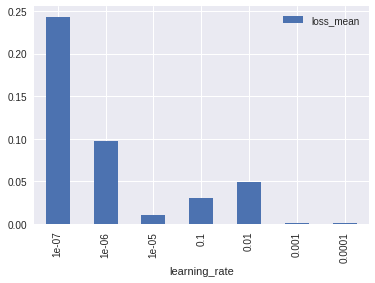

In [ ]:
lr_models_df_ld = pd.read_pickle(os.path.join(lr_path, "lr_results.pkl"))
lr_models_df_ld.plot.bar( x = 'learning_rate', y = 'loss_mean')
lr_models_df_ld[ lr_models_df_ld.loss_mean == lr_models_df_ld.loss_mean.min()]

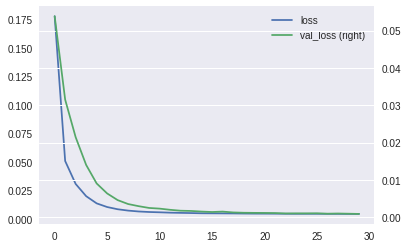

In [ ]:
lr_best_model = "window_size=32_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"
lr_best_model_path = os.path.join(lr_path,lr_best_model)
lr_best_model_history = np.load(os.path.join(lr_best_model_path, "history.npy"), allow_pickle=True)

lr_best_model_history = pd.DataFrame(lr_best_model_history.item())


lr_best_model_history.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True)
plt.show()

In [ ]:
# evaluate window_size
# optimal window_size: 250

model_names = [ "window_size=500_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=125_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=72_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=48_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=24_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"
               ]

hparam = 'window_size'
hparam_vals = [ 500, 250, 125,72, 48, 24 ]



ws_models_df = eval_experiment(hparam, hparam_vals, model_names, ws_path)
ws_models_df.drop(["model"],  axis=1).to_pickle(os.path.join(ws_path, hparam + ".pkl"))

696/696 [==============================] - 29s 41ms/step - loss: 5.4849e-04 - root_mean_squared_error: 0.0234 - nse: 0.9655 - mean_absolute_error: 0.0141 - maxe: 0.1262 - rev: -2.2177
means: [ 5.48488053e-04  2.34198272e-02  9.65487599e-01  1.41411107e-02
  1.26206875e-01 -2.21766019e+00], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 15s 22ms/step - loss: 6.9658e-04 - root_mean_squared_error: 0.0264 - nse: 0.9125 - mean_absolute_error: 0.0154 - maxe: 0.1195 - rev: 0.0253
means: [6.96583360e-04 2.63928678e-02 9.12521005e-01 1.54134845e-02
 1.19473293e-01 2.52593476e-02], varis: [0. 0. 0. 0. 0. 0.]
707/707 [==============================] - 11s 15ms/step - loss: 7.2870e-04 - root_mean_squared_error: 0.0270 - nse: 0.8100 - mean_absolute_error: 0.0160 - maxe: 0.1081 - rev: -0.4355
means: [ 7.28698855e-04  2.69944202e-02  8.09979618e-01  1.60208959e-02
  1.08073458e-01 -4.35499430e-01], varis: [0. 0. 0. 0. 0. 0.]
709/709 [==============================] - 7s 10ms/st

In [ ]:
ws_models_df_ld = pd.read_pickle(os.path.join(ws_path,'window_size'+ ".pkl"))
ws_models_df_ld.sort_values(by=['window_size'], inplace=True)

ws_models_df_ld['window_size'] = ws_models_df_ld['window_size'].apply(str)

ws_models_df_ld.plot.bar( x = 'window_size', 
                         y = 'loss_mean', 
                         labels={
                     "window_size": "window size",
                     "loss_mean": "loss"},
                      width=2*500,
                      height=500,
                         text = ws_models_df_ld['loss_mean'].round(4) )

,window_size,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
0,250,0.000594,0.024371,0.92591,0.014302,0.112302,-0.02911,0.0,0.0,0.0,0.0,0.0,0.0


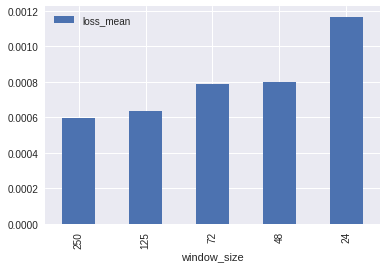

In [ ]:
ws_models_df_ld =  pd.read_pickle(os.path.join(ws_path,'window_size'+ ".pkl"))
ws_models_df_ld.plot.bar( x = 'window_size', y = 'loss_mean')
ws_models_df_ld[ ws_models_df_ld.loss_mean == ws_models_df_ld.loss_mean.min()]

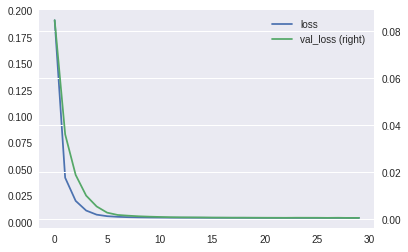

In [ ]:
ws_best_model = "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"
ws_best_model_path = os.path.join(ws_path, ws_best_model)
ws_best_model_history = np.load(os.path.join(ws_best_model_path, "history.npy"), allow_pickle=True)

ws_best_model_history = pd.DataFrame(ws_best_model_history.item())


ws_best_model_history.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True)
plt.show()

In [ ]:
# optimise batch size
# optimal batchsize: 32

model_names = ["window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=1024_nr_layers=1", 
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=512_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=256_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=128_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=64_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

hparam = 'batch_size'
hparam_vals = [1024, 512, 256, 128, 64, 32]

bs_models_df = eval_experiment(hparam, hparam_vals, model_names, bs_path)
bs_models_df.drop(["model"],  axis=1).to_pickle(os.path.join(bs_path, hparam + ".pkl"))


679/679 [==============================] - 52s 76ms/step - loss: 0.0286 - root_mean_squared_error: 0.1691 - nse: -0.0149 - mean_absolute_error: 0.1030 - maxe: 0.6477 - rev: -252.2083
means: [ 2.86025219e-02  1.69122800e-01 -1.48883490e-02  1.03020266e-01
  6.47699594e-01 -2.52208282e+02], varis: [0. 0. 0. 0. 0. 0.]
695/695 [==============================] - 28s 40ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - nse: 0.0172 - mean_absolute_error: 0.0732 - maxe: 0.5267 - rev: -5.7132
means: [ 0.01596279  0.12634392  0.01724625  0.07318443  0.52665979 -5.71322203], varis: [0. 0. 0. 0. 0. 0.]
703/703 [==============================] - 16s 22ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - nse: 0.4957 - mean_absolute_error: 0.0367 - maxe: 0.2816 - rev: -5.2338
means: [ 0.00563009  0.07503396  0.49565417  0.03672704  0.28158244 -5.2337575 ], varis: [0. 0. 0. 0. 0. 0.]
707/707 [==============================] - 10s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395

In [ ]:
bs_models_df_ld = pd.read_pickle(os.path.join(bs_path,'batch_size'+ ".pkl"))
bs_models_df_ld.sort_values(by=['batch_size'], inplace=True)

bs_models_df_ld['batch_size'] = bs_models_df_ld['batch_size'].apply(str)

bs_models_df_ld.plot.bar( x = 'batch_size', 
                         y = 'loss_mean', 
                         labels={
                     "batch_size": "batch size",
                     "loss_mean": "loss"},
                      width=2*500,
                      height=500,
                         text = bs_models_df_ld['loss_mean'].round(4) )

,model,batch_size,loss_mean,rmse_mean,nse_mean,meae_mean,max_err_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,max_err_variance,rev_variance
5,<tensorflow.python.keras.engine.sequential.Seq...,32,0.001699,0.041213,-0.167573,0.02726,0.082594,4.775105,0.0,0.0,0.0,0.0,0.0,0.0


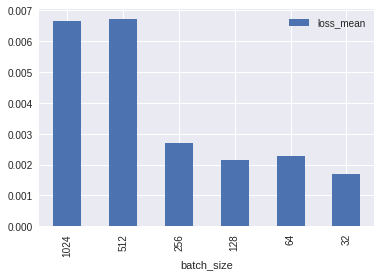

In [ ]:
bs_models_df_ld =  pd.read_pickle(os.path.join(bs_path,'batch_size'+ ".pkl"))
bs_models_df_ld.plot.bar( x =  'batch_size', y = 'loss_mean')
bs_models_df_ld[ bs_models_df_ld.loss_mean == bs_models_df_ld.loss_mean.min()]

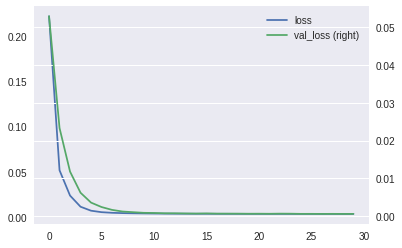

In [ ]:
bs_best_model = "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"
bs_best_model_path = os.path.join(bs_path, bs_best_model)
bs_best_model_history = np.load(os.path.join(bs_best_model_path, "history.npy"), allow_pickle=True)

bs_best_model_history = pd.DataFrame(bs_best_model_history.item())


bs_best_model_history.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True)
plt.show()

In [ ]:
# optimise nr_layers
# optimal nr_layers: 1

model_names = ["window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1", 
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=2"]

hparam = 'layers'
hparam_vals = [1,2]


ls_models_df = eval_experiment(hparam, hparam_vals, model_names, ls_path)
ls_models_df.drop(["model"],  axis=1).to_pickle(os.path.join(ls_path, hparam + ".pkl"))

704/704 [==============================] - 16s 22ms/step - loss: 6.3080e-04 - root_mean_squared_error: 0.0251 - nse: 0.9314 - mean_absolute_error: 0.0153 - maxe: 0.1127 - rev: -0.3993
means: [ 6.30803639e-04  2.51158085e-02  9.31443214e-01  1.52737042e-02
  1.12738945e-01 -3.99318874e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 25s 35ms/step - loss: 0.0044 - root_mean_squared_error: 0.0667 - nse: 0.2965 - mean_absolute_error: 0.0288 - maxe: 0.1340 - rev: 6.6130
means: [4.44440031e-03 6.66663274e-02 2.96533555e-01 2.87658572e-02
 1.33965492e-01 6.61295366e+00], varis: [0. 0. 0. 0. 0. 0.]


In [ ]:
ls_models_df_ld = pd.read_pickle(os.path.join(ls_path,'layers'+ ".pkl"))
ls_models_df_ld.sort_values(by=['layers'], inplace=True)

ls_models_df_ld['layers'] = ls_models_df_ld['layers'].apply(str)

ls_models_df_ld.plot.bar( x = 'layers', 
                         y = 'loss_mean', 
                         labels={
                     "layers": "nr layers",
                     "loss_mean": "loss"},
                      width=2*500,
                      height=500,
                         text = ls_models_df_ld['loss_mean'].round(4) )

,layers,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
0,1,0.000631,0.025116,0.931443,0.015274,0.112739,-0.399319,0.0,0.0,0.0,0.0,0.0,0.0


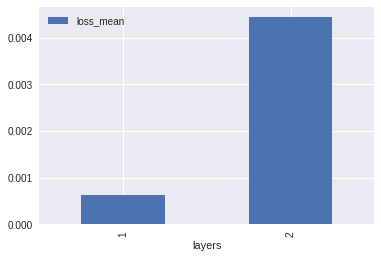

In [ ]:
ls_models_df_ld =  pd.read_pickle(os.path.join(ls_path,'layers'+ ".pkl"))
ls_models_df_ld.plot.bar( x =  'layers', y = 'loss_mean')
ls_models_df_ld[ ls_models_df_ld.loss_mean == ls_models_df_ld.loss_mean.min()]

In [ ]:
# optimise nr_units
# optimal nr_units: 32

model_names = ["window_size=250_num_units=128_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1", 
               "window_size=250_num_units=64_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=16_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

hparam = 'num_units'
hparam_vals = [128, 64, 32, 16]

 
ls_models_df = eval_experiment(hparam, hparam_vals, model_names, nu_path)
ls_models_df.drop(["model"],  axis=1).to_pickle(os.path.join(nu_path, hparam + ".pkl"))

704/704 [==============================] - 64s 90ms/step - loss: 6.2722e-04 - root_mean_squared_error: 0.0250 - nse_metric: 0.9336 - mean_absolute_error: 0.0148 - max_error: 0.1095 - rev_metric: 0.8283
means: [6.27220958e-04 2.50443816e-02 9.33595240e-01 1.47583149e-02
 1.09477088e-01 8.28285217e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 23s 33ms/step - loss: 5.9169e-04 - root_mean_squared_error: 0.0243 - nse_metric: 0.9426 - mean_absolute_error: 0.0141 - max_error: 0.1153 - rev_metric: 1.1612
means: [5.91693970e-04 2.43247580e-02 9.42590296e-01 1.40733365e-02
 1.15289800e-01 1.16123331e+00], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 16s 23ms/step - loss: 5.7526e-04 - root_mean_squared_error: 0.0240 - nse_metric: 0.9369 - mean_absolute_error: 0.0144 - max_error: 0.1177 - rev_metric: -0.8928
means: [ 5.75264276e-04  2.39846557e-02  9.36877966e-01  1.43517526e-02
  1.17697075e-01 -8.92785609e-01], varis: [0. 0. 0. 0. 0. 0.]
704

,num_units,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
2,32,0.000575,0.023985,0.936878,0.014352,0.117697,-0.892786,0.0,0.0,0.0,0.0,0.0,0.0


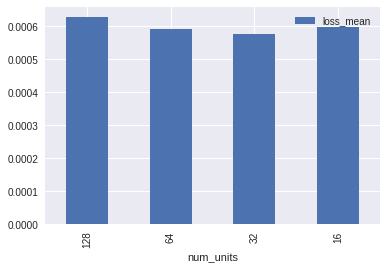

In [ ]:
nu_models_df_ld =  pd.read_pickle(os.path.join(nu_path,'num_units'+ ".pkl"))
nu_models_df_ld.plot.bar( x =  'num_units', y = 'loss_mean')
nu_models_df_ld[ nu_models_df_ld.loss_mean == nu_models_df_ld.loss_mean.min()]

In [ ]:
model_names = ["window_size=250_num_units=32_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.4_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.2_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

dropout_vals = [ 0.5,0.4,0.2,0.1]
dropout =  "dropout"
dropout_df = eval_experiment(dropout, dropout_vals, model_names, do_path)
dropout_df.drop(["model"],  axis=1).to_pickle(os.path.join(do_path, "dropout.pkl"))

dropout_df[ dropout_df.loss_mean == dropout_df.loss_mean.min()]

704/704 [==============================] - 15s 21ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - nse: 0.8030 - mean_absolute_error: 0.0252 - maxe: 0.1272 - rev: -2.7431
means: [ 1.24262611e-03  3.52508873e-02  8.03003132e-01  2.52496470e-02
  1.27243891e-01 -2.74311471e+00], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 15s 21ms/step - loss: 7.8781e-04 - root_mean_squared_error: 0.0281 - nse: 0.8946 - mean_absolute_error: 0.0186 - maxe: 0.1240 - rev: -0.2647
means: [ 7.87807163e-04  2.80678999e-02  8.94588232e-01  1.86267141e-02
  1.24023013e-01 -2.64666796e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 15s 22ms/step - loss: 6.7430e-04 - root_mean_squared_error: 0.0260 - nse: 0.9191 - mean_absolute_error: 0.0163 - maxe: 0.1175 - rev: -0.8460
means: [ 6.74301817e-04  2.59673204e-02  9.19094324e-01  1.63059849e-02
  1.17450759e-01 -8.46001387e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 15s 21m

,model,dropout,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
3,<tensorflow.python.keras.engine.sequential.Seq...,0.1,0.000599,0.024472,0.93785,0.014356,0.116131,-0.056928,0.0,0.0,0.0,0.0,0.0,0.0


,dropout,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
3,0.1,0.000599,0.024472,0.93785,0.014356,0.116131,-0.056928,0.0,0.0,0.0,0.0,0.0,0.0


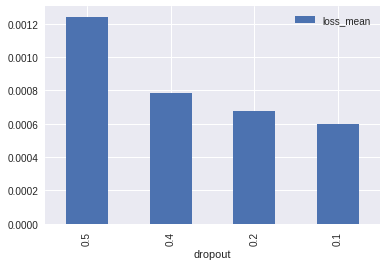

In [ ]:
do_models_df_ld =  pd.read_pickle(os.path.join(do_path,"dropout.pkl"))
do_models_df_ld.plot.bar( x =  'dropout', y = 'loss_mean')
do_models_df_ld[ do_models_df_ld.loss_mean == do_models_df_ld.loss_mean.min()]

In [ ]:
model_names = ["window_size=250_num_units=128_dropout=0.25_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=128_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=128_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=64_dropout=0.25_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=64_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=64_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.25_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1",
               "window_size=250_num_units=32_dropout=0.1_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

vals = [ (128, 0.25), (128, 0.5), (128, 0.1), (64, 0.5), (64, 0.5), (64, 0.1), (32, 0.25), (32, 0.5), (32, 0.1)]
param =  "nudo"

nudo_df = eval_experiment(param, vals, model_names, nudo_path)
nudo_df.drop(["model"],  axis=1).to_pickle(os.path.join(nudo_path, "nudo.pkl"))
nudo_df[ nudo_df.loss_mean == nudo_df.loss_mean.min()]

704/704 [==============================] - 58s 82ms/step - loss: 5.5431e-04 - root_mean_squared_error: 0.0235 - nse: 0.9325 - mean_absolute_error: 0.0149 - maxe: 0.1021 - rev: 0.4387
means: [5.54314756e-04 2.35438943e-02 9.32534754e-01 1.48724597e-02
 1.02076218e-01 4.38699543e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 58s 82ms/step - loss: 4.9030e-04 - root_mean_squared_error: 0.0221 - nse: 0.9460 - mean_absolute_error: 0.0133 - maxe: 0.1041 - rev: 0.5323
means: [4.90296341e-04 2.21426282e-02 9.45951998e-01 1.32540585e-02
 1.04092188e-01 5.32325566e-01], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 58s 82ms/step - loss: 6.1740e-04 - root_mean_squared_error: 0.0248 - nse: 0.9390 - mean_absolute_error: 0.0148 - maxe: 0.1040 - rev: 1.0812
means: [6.17398473e-04 2.48475075e-02 9.39033270e-01 1.47990175e-02
 1.04048043e-01 1.08119535e+00], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 28s 39ms/step - loss: 5.

NameError: ignored

,model,nudo,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
1,<tensorflow.python.keras.engine.sequential.Seq...,"(128, 0.5)",0.00049,0.022143,0.945952,0.013254,0.104092,0.532326,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nudo_df_ld

,nudo,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
8,"(32, 0.1)",0.000606,0.024608,0.934801,0.014666,0.113559,1.119736,0.0,0.0,0.0,0.0,0.0,0.0
6,"(32, 0.25)",0.000700,0.026467,0.920053,0.016588,0.117409,-0.774044,0.0,0.0,0.0,0.0,0.0,0.0
7,"(32, 0.5)",0.001328,0.036438,0.798441,0.026362,0.128838,-2.026374,0.0,0.0,0.0,0.0,0.0,0.0
5,"(64, 0.1)",0.000615,0.024794,0.903780,0.014685,0.105130,0.591720,0.0,0.0,0.0,0.0,0.0,0.0
3,"(64, 0.5)",0.000570,0.023883,0.927489,0.014622,0.115907,0.352093,0.0,0.0,0.0,0.0,0.0,0.0
4,"(64, 0.5)",0.000784,0.028003,0.895420,0.019021,0.115458,-0.815907,0.0,0.0,0.0,0.0,0.0,0.0
2,"(128, 0.1)",0.000617,0.024848,0.939033,0.014799,0.104048,1.081195,0.0,0.0,0.0,0.0,0.0,0.0
0,"(128, 0.25)",0.000554,0.023544,0.932535,0.014872,0.102076,0.438700,0.0,0.0,0.0,0.0,0.0,0.0
1,"(128, 0.5)",0.000490,0.022143,0.945952,0.013254,0.104092,0.532326,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nudo_df_ld

,nudo,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
0,"(128, 0.25)",0.000554,0.023544,0.932535,0.014872,0.102076,0.438700,0.0,0.0,0.0,0.0,0.0,0.0
1,"(128, 0.5)",0.000490,0.022143,0.945952,0.013254,0.104092,0.532326,0.0,0.0,0.0,0.0,0.0,0.0
2,"(128, 0.1)",0.000617,0.024848,0.939033,0.014799,0.104048,1.081195,0.0,0.0,0.0,0.0,0.0,0.0
3,"(64, 0.25)",0.000570,0.023883,0.927489,0.014622,0.115907,0.352093,0.0,0.0,0.0,0.0,0.0,0.0
4,"(64, 0.5)",0.000784,0.028003,0.895420,0.019021,0.115458,-0.815907,0.0,0.0,0.0,0.0,0.0,0.0
5,"(64, 0.1)",0.000615,0.024794,0.903780,0.014685,0.105130,0.591720,0.0,0.0,0.0,0.0,0.0,0.0
6,"(32, 0.25)",0.000700,0.026467,0.920053,0.016588,0.117409,-0.774044,0.0,0.0,0.0,0.0,0.0,0.0
7,"(32, 0.5)",0.001328,0.036438,0.798441,0.026362,0.128838,-2.026374,0.0,0.0,0.0,0.0,0.0,0.0
8,"(32, 0.1)",0.000606,0.024608,0.934801,0.014666,0.113559,1.119736,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nudo_df_ld =  pd.read_pickle(os.path.join(nudo_path,"nudo.pkl"))
nudo_df_ld.at[3, "nudo"] = (64, 0.25)

nudo_df_ld.sort_values(by=['nudo'], inplace=True)

nudo_df_ld['nudo'] = nudo_df_ld['nudo'].apply(str)

nudo_df_ld.plot.bar( x = 'nudo', 
                         y = 'loss_mean', 
                         labels={
                     "nudo": "nr. units, drop out",
                     "loss_mean": "loss"},
                      width=2*500,
                      height=500,
                         text = nudo_df_ld['loss_mean'].round(4) )

,nudo,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
1,"(128, 0.5)",0.00049,0.022143,0.945952,0.013254,0.104092,0.532326,0.0,0.0,0.0,0.0,0.0,0.0


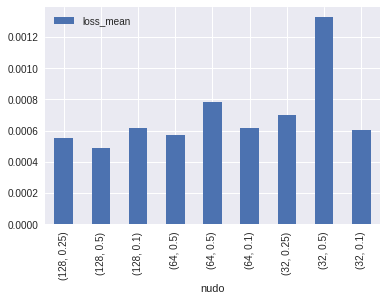

In [ ]:
nudo_df_ld =  pd.read_pickle(os.path.join(nudo_path,"nudo.pkl"))
nudo_df_ld.plot.bar( x =  'nudo', y = 'loss_mean')
nudo_df_ld[ nudo_df_ld.loss_mean == nudo_df_ld.loss_mean.min()]

In [ ]:
model_names = ["window_size=250_num_units=128_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"]

vals = ["gru"]
param =  "unit"

unit_df = eval_experiment(param, vals, model_names, unit_path)
unit_df.drop(["model"],  axis=1).to_pickle(os.path.join(unit_path, "unit.pkl"))
unit_df[ unit_df.loss_mean == unit_df.loss_mean.min()]

704/704 [==============================] - 48s 69ms/step - loss: 5.7404e-04 - root_mean_squared_error: 0.0240 - nse: 0.9422 - mean_absolute_error: 0.0148 - maxe: 0.0955 - rev: 1.3880
means: [5.74035803e-04 2.39590444e-02 9.42223966e-01 1.48404296e-02
 9.54846144e-02 1.38799393e+00], varis: [0. 0. 0. 0. 0. 0.]


,model,unit,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
0,<tensorflow.python.keras.engine.sequential.Seq...,gru,0.000574,0.023959,0.942224,0.01484,0.095485,1.387994,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model_names = ['standard_with_input_dropout', 'standard_with_parameter_dropout', 'standard_with_all_dropouts', 'standard_wit_input_and_output_dropout']
p =os.path.join(path, 'temp')

vals = ["input", "param", "all", "inpu&output"]
param =  "do_position"
input_dropout_df = eval_experiment(param, vals, model_names, p)
input_dropout_df[ input_dropout_df.loss_mean == input_dropout_df.loss_mean.min()]

704/704 [==============================] - 56s 80ms/step - loss: 0.1479 - root_mean_squared_error: 0.3845 - nse: -22.0324 - mean_absolute_error: 0.2943 - maxe: 0.4380 - rev: -39.8725
means: [  0.14785287   0.38451654 -22.03235245   0.29433218   0.43797359
 -39.87245178], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 57s 81ms/step - loss: 0.1452 - root_mean_squared_error: 0.3811 - nse: -20.3114 - mean_absolute_error: 0.2851 - maxe: 0.4236 - rev: -33.0177
means: [  0.14523536   0.38109764 -20.31141853   0.28508827   0.42357004
 -33.01774979], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 57s 81ms/step - loss: 0.3176 - root_mean_squared_error: 0.5636 - nse: -49.4490 - mean_absolute_error: 0.4293 - maxe: 0.6070 - rev: -53.3332
means: [  0.31761903   0.56357706 -49.44898987   0.42925951   0.6069954
 -53.33321762], varis: [0. 0. 0. 0. 0. 0.]
704/704 [==============================] - 57s 81ms/step - loss: 0.1294 - root_mean_squared_error: 0.359

,model,do_position,loss_mean,rmse_mean,nse_mean,meae_mean,maxe_mean,rev_mean,loss_variance,rmse_variance,nse_variance,meae_variance,maxe_variance,rev_variance
3,<tensorflow.python.keras.engine.sequential.Seq...,inpu&output,0.129437,0.359773,-16.824266,0.244531,0.382925,-23.442558,0.0,0.0,0.0,0.0,0.0,0.0


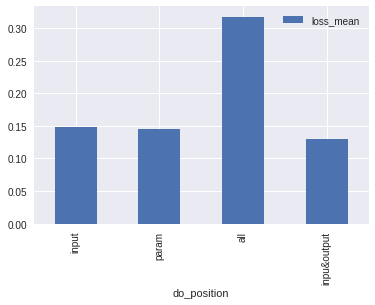

In [ ]:
input_dropout_df.plot.bar( x =  'do_position', y = 'loss_mean')

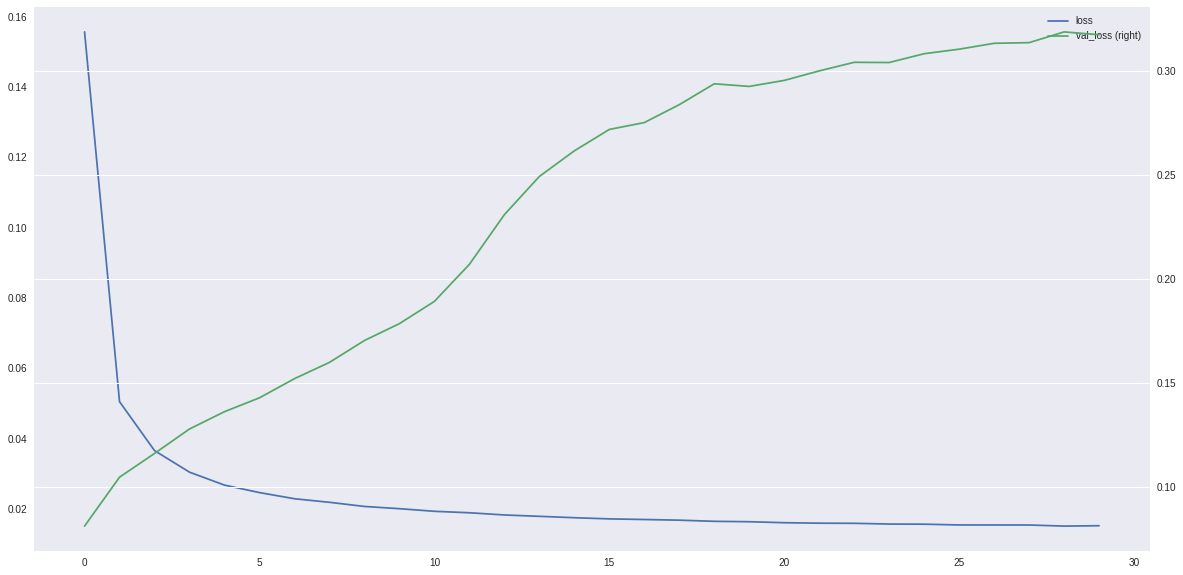

In [ ]:
t_hist = np.load(os.path.join(os.path.join(p, ), "standard_with_all_dropouts", "history.npy"), allow_pickle=True)
t_hist =  pd.DataFrame(t_hist.item())
t_hist.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True,figsize=(20,10) )

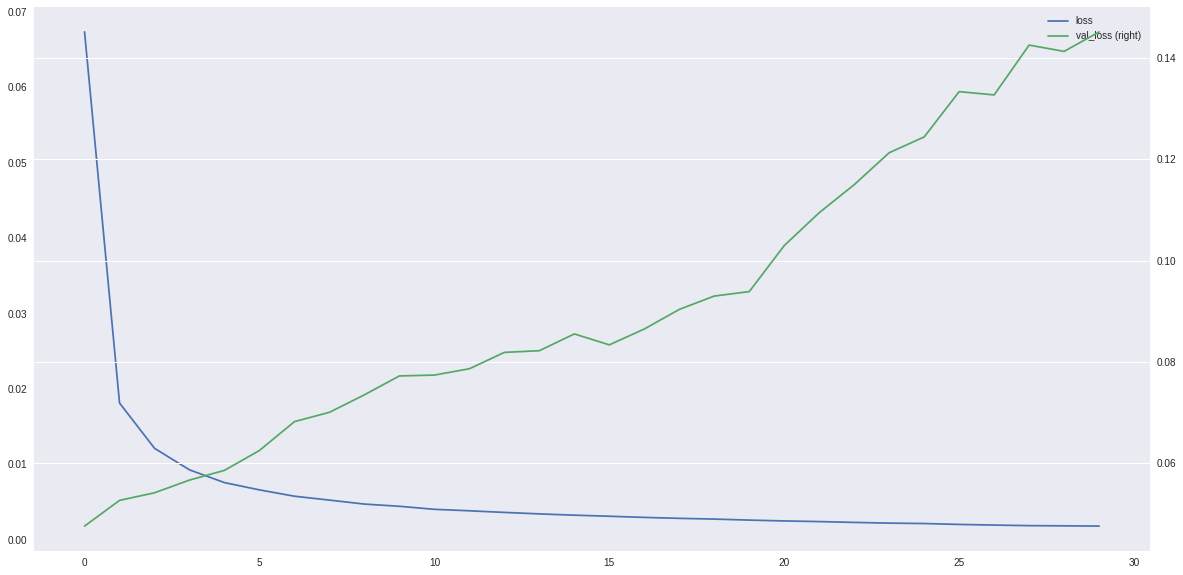

In [ ]:
t_hist = np.load(os.path.join(os.path.join(p, ), "standard_with_parameter_dropout", "history.npy"), allow_pickle=True)
t_hist =  pd.DataFrame(t_hist.item())
t_hist.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True,figsize=(20,10) )


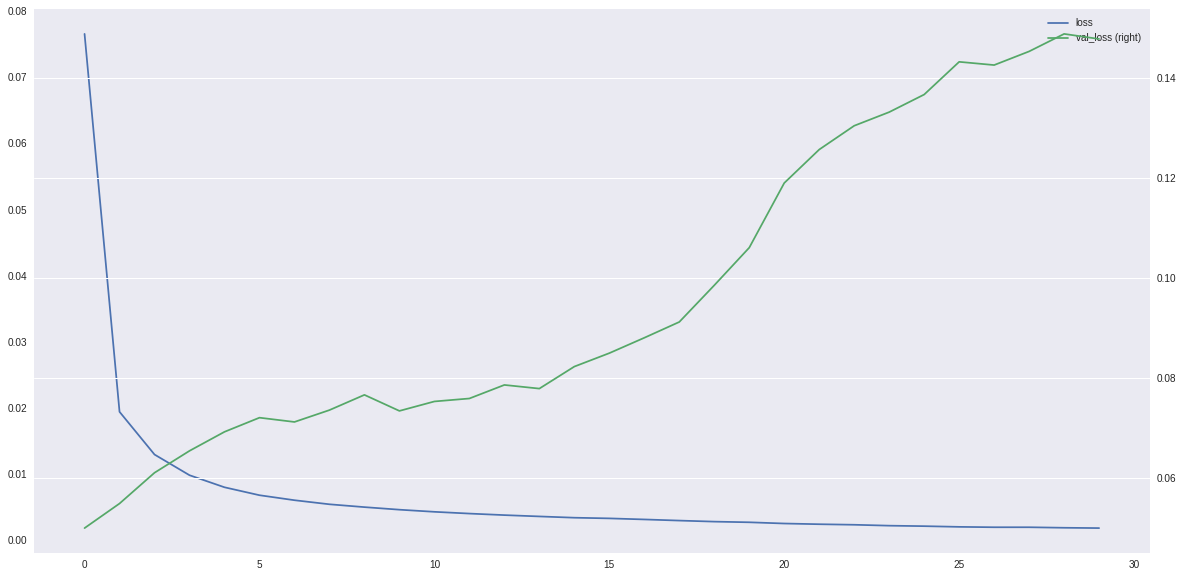

In [ ]:
t_hist = np.load(os.path.join(os.path.join(p, ), "standard_with_input_dropout", "history.npy"), allow_pickle=True)
t_hist =  pd.DataFrame(t_hist.item())
t_hist.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True,figsize=(20,10) )


In [ ]:
bs_best_model = "window_size=250_num_units=128_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"

bs_best_model_path = os.path.join(nudo_path, bs_best_model)
bs_best_model_history = np.load(os.path.join(bs_best_model_path, "history.npy"), allow_pickle=True)

bs_best_model_history = pd.DataFrame(bs_best_model_history.item())
"""
,
                      width=2*500,
                      height=500,
                         text = nudo_df_ld['loss_mean'].round(4) 


"""

bs_best_model_history.plot(y = ['loss', "val_loss"], 
                           labels={
                              "value": "loss",
                              "index": "epochs"},
                            width=2*500,
                            height=500
                      )

In [ ]:
mp = os.path.join(path, "3times_best_model")

tt = np.load(os.path.join(mp, "m3", "history.npy"), allow_pickle=True)
tt_df = pd.DataFrame(tt.item())
tt_df.plot(y = ['loss', "val_loss"], use_index=True,figsize=(20,10) )


FileNotFoundError: ignored

len(val_df["q_MARI"]: 22747


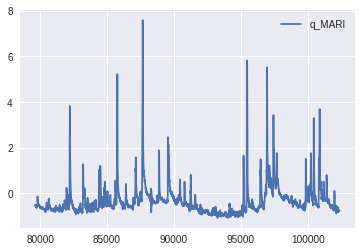

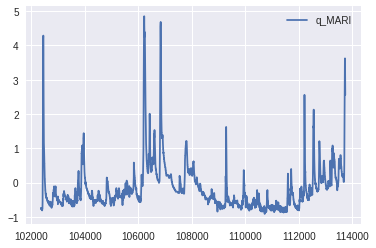

In [ ]:
print(f'len(val_df["q_MARI"]: {len(val_df["q_MARI"])}')
# train_df_normal_fill.plot(y = ['q_MARI'], use_index = True)
val_df_normal_fill.plot(y = ['q_MARI'], use_index = True)
test_df_normal_fill.plot(y = ['q_MARI'], use_index = True)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 250, 128)          90624     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 250, 1)            129       
Total params: 90,753
Trainable params: 90,753
Non-trainable params: 0
_________________________________________________________________


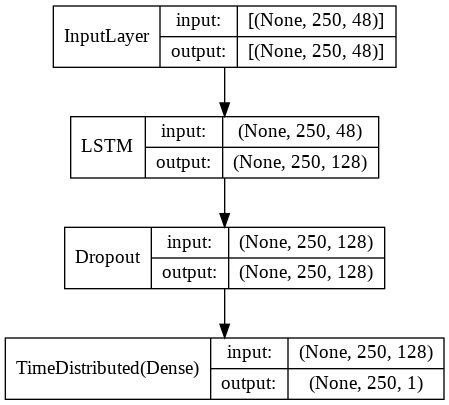

In [ ]:
# predict entire validation set
window_ones = WindowGenerator(input_width= 1, label_width=1, shift=1,label_columns=['q_MARI'])
# predictions = best_model.predict(window_ones.val)

model_name = "window_size=250_num_units=128_dropout=0.5_optimizer=adam_learning_rate=0.0001_batch_size=32_nr_layers=1"
model_path = os.path.join(nudo_path, model_name)

model = tf.keras.models.load_model(model_path,
      custom_objects={"maxe": max_error, 
                  "meae": median_absolute_error, 
                  "rev": rev_metric, 
                  "nse": nse_metric})
    
model.compile(loss=tf.losses.MeanSquaredError(), optimizer="adam", metrics=get_metrics())
model.summary()

img_file = "test.png"
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=False)

In [ ]:
model.predict(window_0.train)

array([[[-0.10004877],
        [-0.07669125],
        [-0.07887319],
        ...,
        [ 0.905435  ],
        [ 1.0433156 ],
        [ 1.1793853 ]],

       [[-0.09945102],
        [-0.07651281],
        [-0.07918615],
        ...,
        [ 1.0433156 ],
        [ 1.1793853 ],
        [ 1.376558  ]],

       [[-0.09971932],
        [-0.07681861],
        [-0.07965214],
        ...,
        [ 1.1793853 ],
        [ 1.376558  ],
        [ 1.6038668 ]],

       ...,

       [[-0.48722324],
        [-0.5579165 ],
        [-0.56797165],
        ...,
        [-0.5145047 ],
        [-0.4990404 ],
        [-0.5105783 ]],

       [[-0.500729  ],
        [-0.5593386 ],
        [-0.5683882 ],
        ...,
        [-0.49904042],
        [-0.5105783 ],
        [-0.51321155]],

       [[-0.5000905 ],
        [-0.55987513],
        [-0.5686163 ],
        ...,
        [-0.5105783 ],
        [-0.5132115 ],
        [-0.5127331 ]]], dtype=float32)

In [ ]:
def compute_metrics(df, start = 0 , end = -1):
  if end == -1:
    end = len(df)

  ys = df["ys"][start:end]
  y_hats =df["y_hats"][start:end]
  
  return {
    "maxe" : max_error(ys, y_hats).numpy(),
    # "maer" :  median_absolute_error(ys, df["y_hats"]),
    "rev"  : rev_metric(ys, y_hats).numpy(),
    "nse" : nse_metric(ys, y_hats).numpy(),
    "mse" : tf.keras.losses.mean_squared_error(ys, y_hats).numpy(),
    "rmse" :  tf.math.sqrt( tf.keras.losses.mean_squared_error(ys, y_hats)).numpy(),
    "meae" : tf.keras.losses.MeanAbsoluteError()(ys, y_hats).numpy()
}


In [ ]:
n_batch = 1
num_features = 48

predict_model =  tf.keras.models.Sequential([
      tf.keras.layers.LSTM(128, batch_input_shape=(1, 1, num_features), 
                           stateful=True,return_sequences=True),

      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))])

predict_model.set_weights(model.get_weights())
predict_model.compile(loss=tf.losses.MeanSquaredError(), optimizer="adam", metrics=get_metrics())



In [ ]:
work_df1 = test_df_normal_fill.copy()

colum_q_MARI1 = list(work_df.columns).index('q_MARI')

ys = work_df['q_MARI'][1:].copy().to_numpy()
xs1 = work_df[:-1].copy().to_numpy()

y_hat1 = xs1[0,colum_q_MARI]
print(y_hat1)

prediction_steps1 = len(ys)  # <= 22746
y_hats1 = [] # store all true predictions
print(f'len(y_hats): {len(y_hats)}, {y_hats}')

predict_model.reset_states()
for i in range(prediction_steps1):
  x = xs[i]
  x[colum_q_MARI] = y_hat
  x = x.reshape(1, 1, num_features)
  y_hat_new = predict_model.predict(x)
  y_hat_new = y_hat_new.flatten()[0]
  # print(f'y_hat_new: {y_hat_new}')
  y_hats1.append(y_hat_new)
  # print(f" i: {i}, y_hat: {y_hat:.4f}, y_hat_new: {y_hat_new:.4f}, y_true: {ys[i]:.4f}")
  y_hat = y_hat_new
  # print(f'len(y_hats): {len(y_hats)}, i: {i}')

y_hats1 = np.asarray(y_hats1)
print(len(y_hats1))
print(len(ys))

-0.7482046124914878
len(y_hats): 11373, [-0.7388934  -0.7108937  -0.68930626 ...  2.4853508   2.3914218
  2.3001585 ]
11373
11373


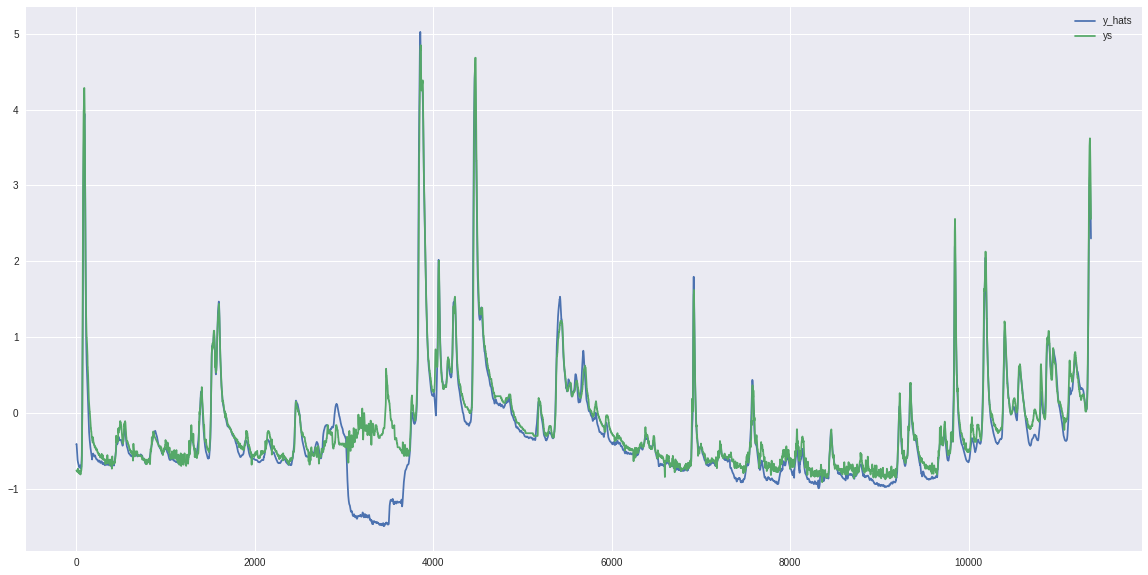

In [ ]:
df_results1 = pd.DataFrame({"ys": ys, "y_hats": y_hats1})
df_results1.to_pickle(path + "result1.pkl")
df_results1.plot(y = [ "y_hats", "ys"], figsize=(20,10))

In [ ]:
df_results = pd.read_pickle(path + "result.pkl")
df_results_dnorm = (df_results*train_std['q_MARI'])+train_mean['q_MARI']

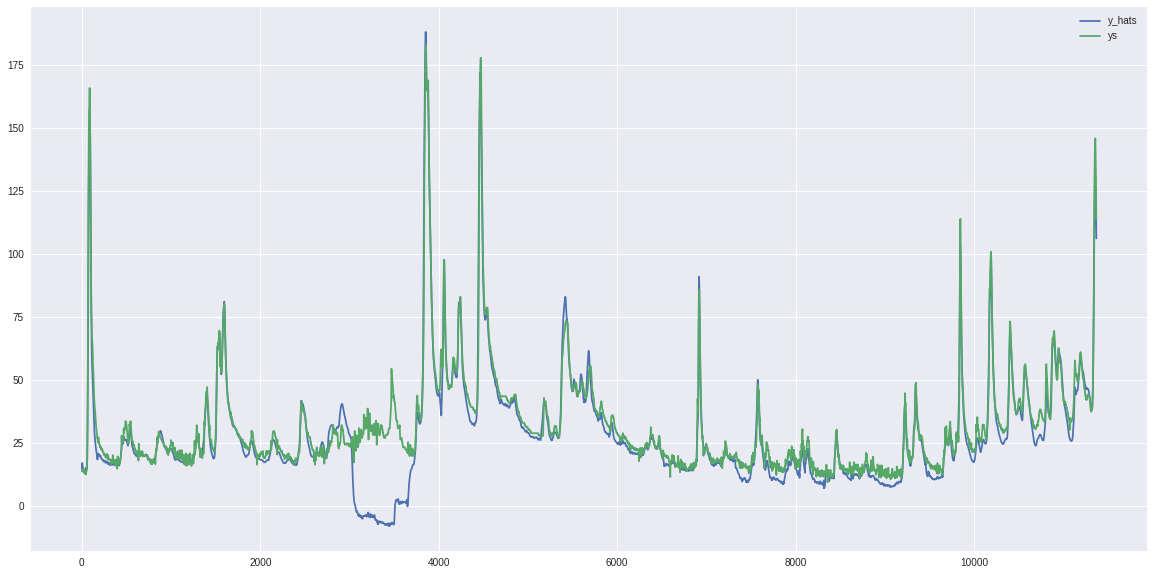

In [ ]:
df_results_dnorm.plot(y = [ "y_hats", "ys"], figsize=(20,10))

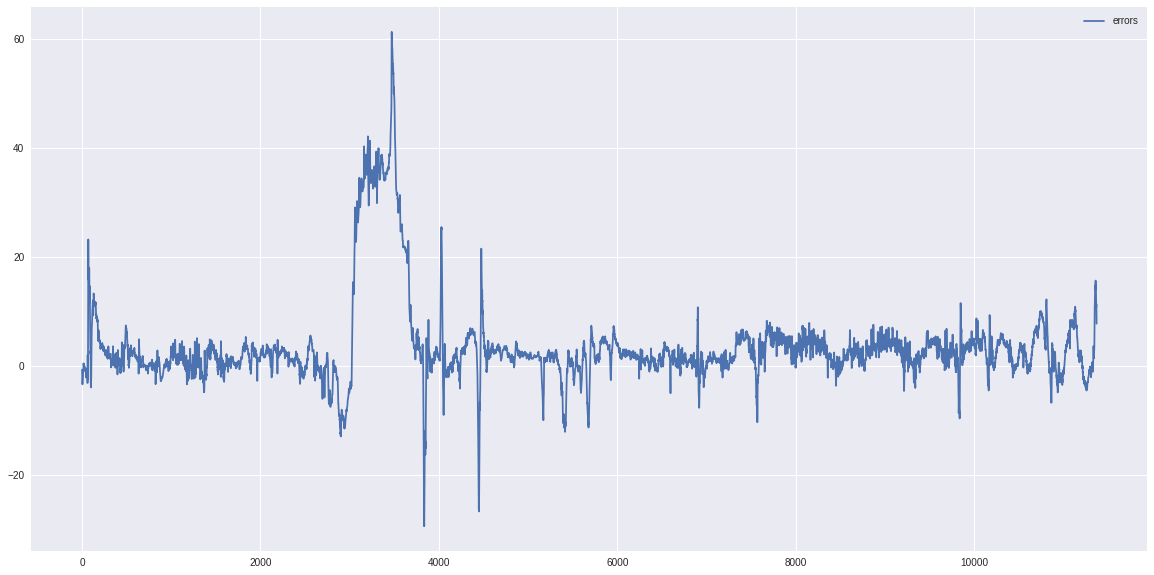

In [ ]:
df_results_dnorm["errors"] = df_results_dnorm['ys']-df_results_dnorm['y_hats']
df_results_dnorm.plot(y = [ "errors"], figsize=(20,10))

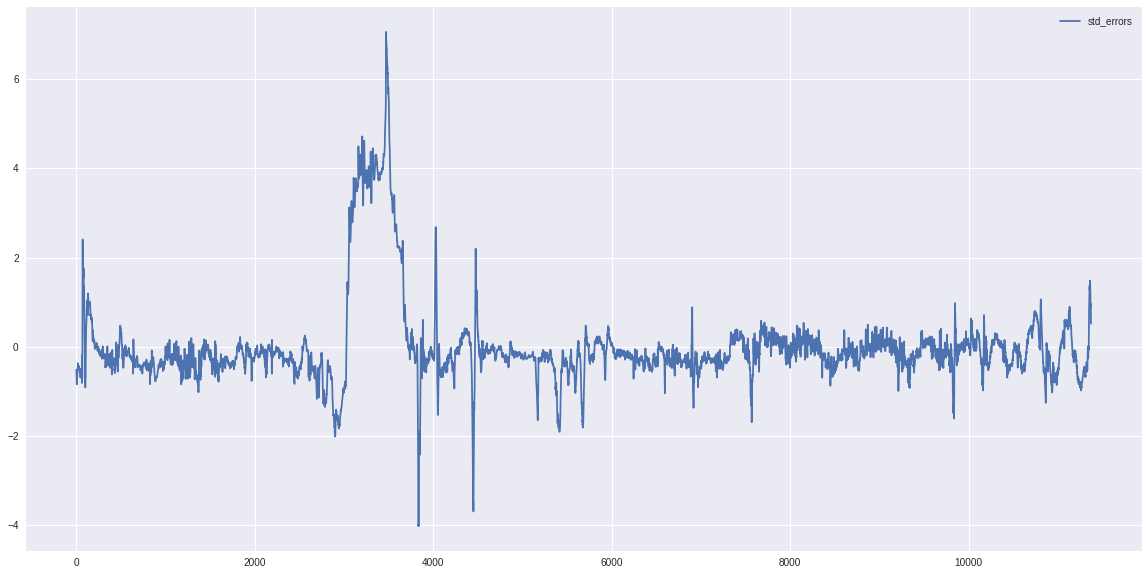

In [ ]:
df_results_dnorm["std_errors"] = (df_results_dnorm["errors"] - df_results_dnorm["errors"].mean())/df_results_dnorm["errors"].std()
df_results_dnorm.plot(y = [ "std_errors"], figsize=(20,10))


[]

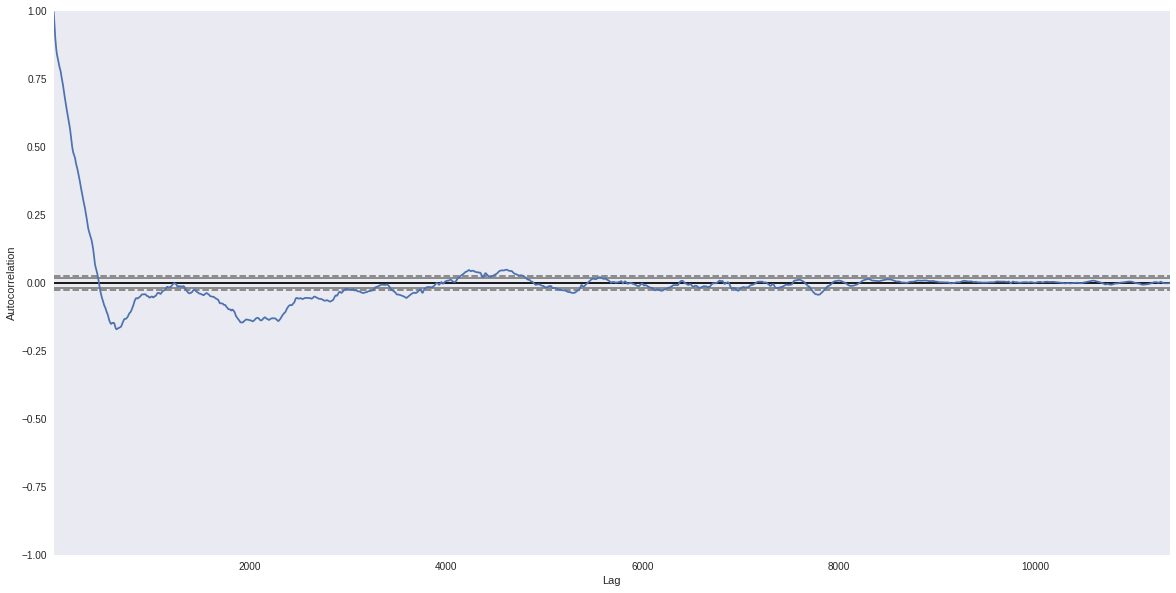

In [ ]:
plt.figure(figsize=(20,10))
x = pd.plotting.autocorrelation_plot(df_results_dnorm["std_errors"])
x.plot() 

In [ ]:
list(range(1,4))

[1, 2, 3]

In [ ]:
y_hats2 = []
# get last two days from validation set

xs2 = val_df_normal_fill[-48:].copy()
xs2 = xs2.append(test_df_normal_fill.copy()).to_numpy()

print(f'{len(xs2)//(48*2)}')


for i in range((len(xs2)//48)):
  s_warmup = i*48
  e_warmup = s_warmup +48

  predict_model.reset_states()
  # warmup for 48h
  for j in range(s_warmup,e_warmup):
    x = xs2[j]
    x = x.reshape(1, 1, num_features)
    predict_model.predict(x)

  # predictions for 48h
  y_hat = xs2[e_warmup,colum_q_MARI]
  for j in range(e_warmup,min(e_warmup+48, len(xs2)-1) ):
    x = xs2[j]
    x[colum_q_MARI] = y_hat
    x = x.reshape(1, 1, num_features)
    y_hat_new = predict_model.predict(x)
    y_hat_new = y_hat_new.flatten()[0]
    y_hats2.append(y_hat_new)
    y_hat = y_hat_new


118


11373
11373


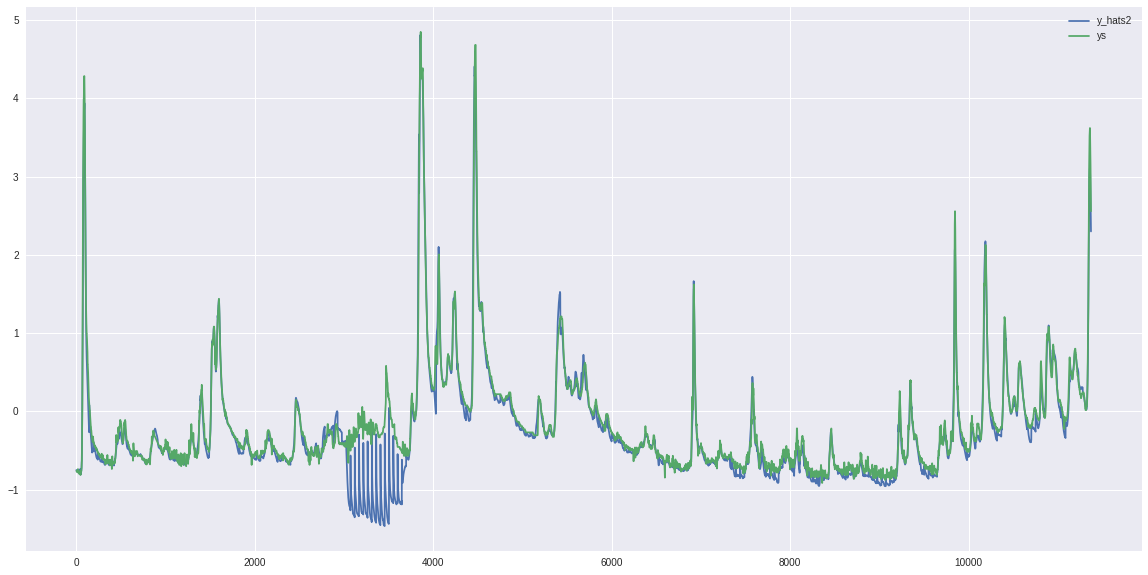

In [ ]:
print(len(y_hats2))
print(len(ys))
y_hats2 = np.asarray(y_hats2)


df_results2 = pd.DataFrame({"ys": ys, "y_hats2": y_hats2})
df_results2.to_pickle(path + "result2.pkl")
df_results2.plot(y = [ "y_hats2", "ys"], figsize=(20,10))

In [ ]:
df_results1 = pd.read_pickle(path + "result1.pkl")
df_results_dnorm = (df_results*train_std['q_MARI'])+train_mean['q_MARI']


In [ ]:
metrics_dict = compute_metrics(df_results)
metrics_dict_denorm = compute_metrics(df_results_dnorm)

print(f'metrics_dict:\n{metrics_dict_denorm}')


metrics_dict:
{'maxe': 29.371872, 'rev': -11.028812, 'nse': 0.8204055, 'mse': 79.39579478930713, 'rmse': 8.910431795895592, 'meae': 4.579442977905273}


In [ ]:
metrics_dict_denorm


{'maxe': 29.371872,
 'meae': 4.579442977905273,
 'mse': 79.39579478930713,
 'nse': 0.8204055,
 'rev': -11.028812,
 'rmse': 8.910431795895592}

22746
22747
[-0.46071815 -0.45768967 -0.46526822 ... -0.706776   -0.7069706
 -0.71127826]


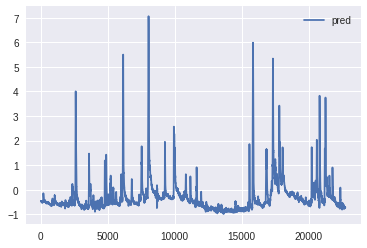

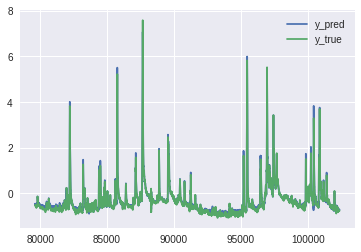

In [ ]:
p2 = predictions.flatten()
pred_df = pd.DataFrame(p2, columns = ["pred"])
print(len(p2))
print(len(val_df))
print(p2)
pred_df.plot(y = "pred", use_index = True)

comp_df =  pd.DataFrame({"y_pred": p2, "y_true":val_df_normal_fill['q_MARI'][1:]})
comp_df.plot(y = ["y_pred","y_true" ],  use_index = True)

Index(['loss', 'root_mean_squared_error', 'nse', 'mean_absolute_error', 'maxe',
       'rev', 'val_loss', 'val_root_mean_squared_error', 'val_nse',
       'val_mean_absolute_error', 'val_maxe', 'val_rev'],
      dtype='object')
Index(['loss', 'root_mean_squared_error', 'nse', 'mean_absolute_error', 'maxe',
       'rev', 'val_loss', 'val_root_mean_squared_error', 'val_nse',
       'val_mean_absolute_error', 'val_maxe', 'val_rev'],
      dtype='object')


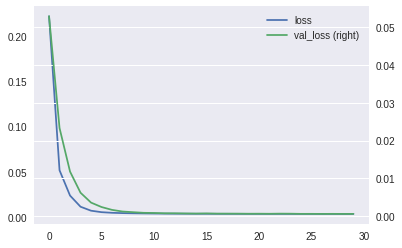

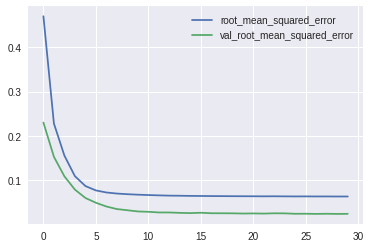

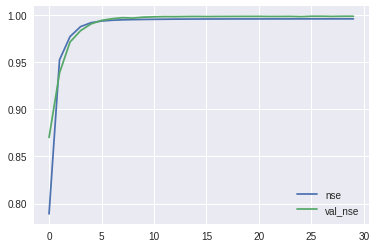

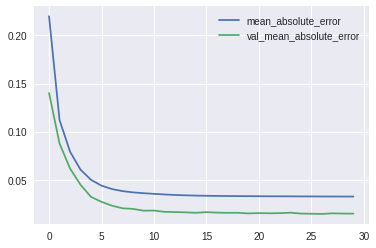

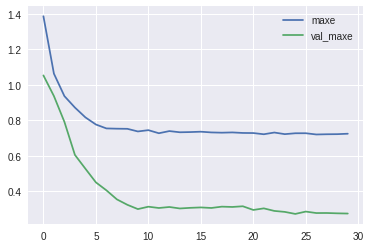

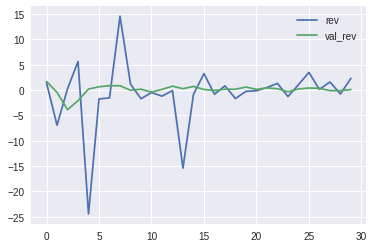

In [ ]:
model_history = np.load(os.path.join(model_path, "history.npy"), allow_pickle=True)

model_history_df = pd.DataFrame(model_history.item())

print(model_history_df.columns)

print(model_history_df.columns)
model_history_df.plot(y = ['loss', "val_loss"], secondary_y = 'val_loss', use_index=True)
plt.show()
model_history_df.plot(y = ['root_mean_squared_error', 'val_root_mean_squared_error'], use_index = True)
model_history_df.plot(y = ['nse', 'val_nse'], use_index = True)
model_history_df.plot(y = ['mean_absolute_error', 'val_mean_absolute_error'], use_index = True)
model_history_df.plot(y = ['maxe', 'val_maxe'], use_index = True)
model_history_df.plot(y = ['rev', 'val_rev'], use_index = True)
